In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bbl import *
from sloped_MITgcm import *

import numpy as np
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

In [3]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.
delta_t = 60.

In [4]:
bbl = bbl_exp(k0, k1, h, N, f, θ)
bbl_f0 = bbl_exp(k0, k1, h, N, 0., θ)

<ipython-input-5-3f3528def619>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,1)
<ipython-input-5-3f3528def619>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,2)
<ipython-input-5-3f3528def619>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

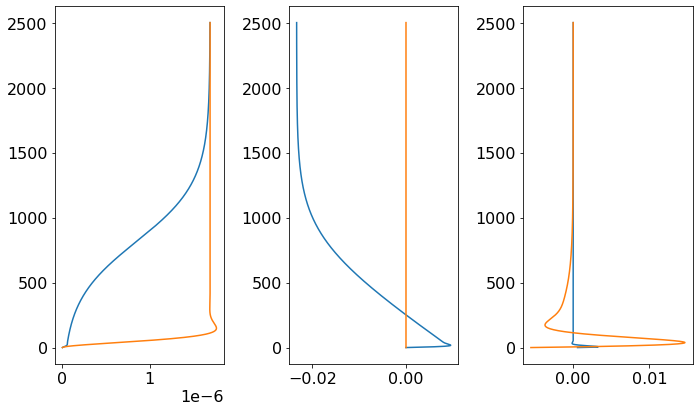

In [5]:
for m in [bbl, bbl_f0]:
    plt.subplot(1,3,1)
    plt.plot(m["bz"], m["z"])
    plt.subplot(1,3,2)
    plt.plot(m["v"], m["z"])
    plt.subplot(1,3,3)
    plt.plot(m["u"], m["z"])
    plt.tight_layout()

In [110]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon/run/"
std = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
std['time'] = std['time'].astype(np.float64)
print(std.time.max()/86400/1e9)
δTδt = (std['THETA'].diff('time', n=1)/np.float64(1.e-9*std['time'].diff('time', n=1))[:, np.newaxis, np.newaxis, np.newaxis])
#std = std.mean(dim='time')
#temp = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
#lvls = open_mdsdataset(data_dir,ignore_unknown_vars=True,levels=[70],prefix=["levelDiag"], delta_t=delta_t)

<xarray.DataArray 'time' ()>
array(2500.)


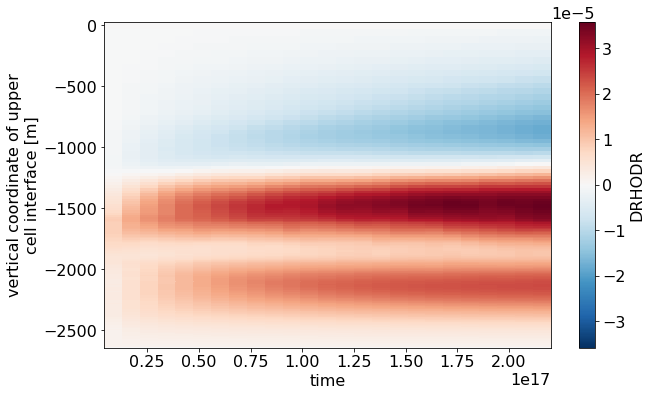

In [118]:
std['DRHODR'].mean(dim=['XC', 'YC']).plot(x='time')

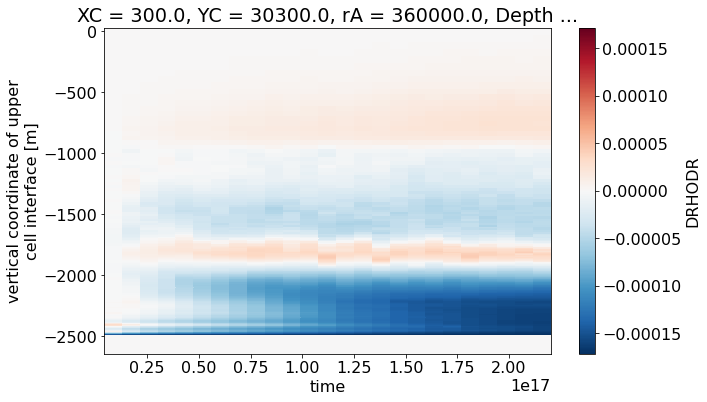

In [126]:
(-std['DRHODR']).isel(YC=50, XC=0).plot(y='Zl')

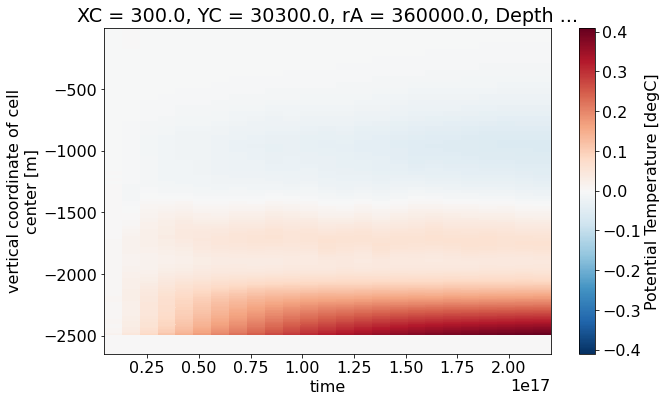

In [131]:
(std['THETA']).isel(YC=50, XC=0).plot(y='Z')

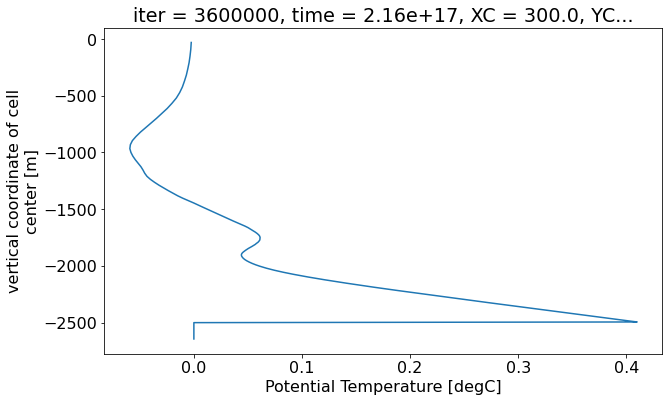

In [135]:
std['THETA'].isel(YC=50, XC=0).isel(time=-1).plot(y='Z')

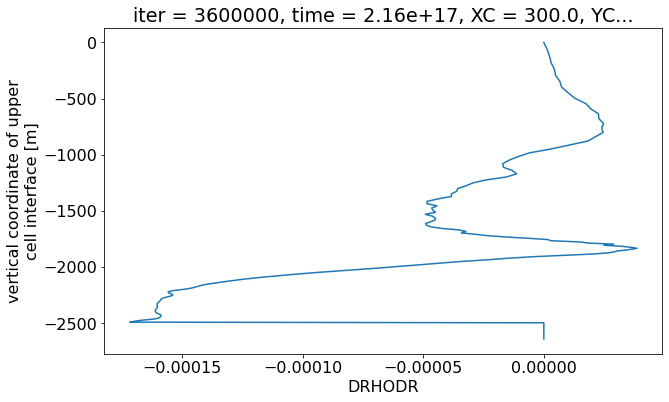

In [125]:
(-std['DRHODR']).isel(YC=50, XC=0).isel(time=-1).plot(y='Zl')

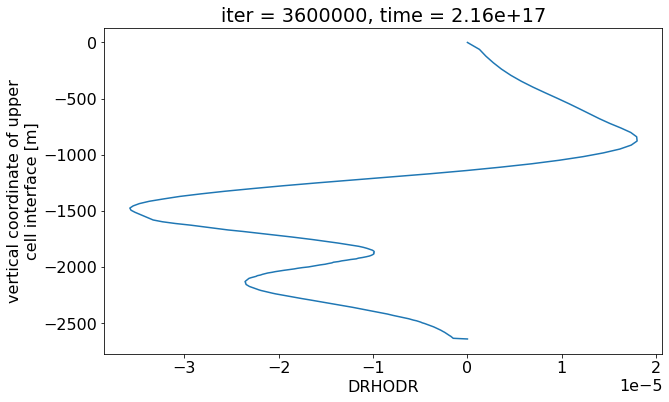

In [124]:
(-std['DRHODR']).mean(dim=['XC', 'YC']).isel(time=-1).plot(y='Zl')

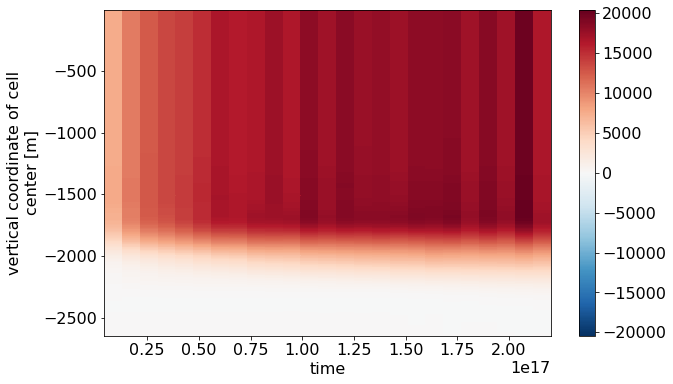

In [103]:
((std['UVEL']*std['drF']*dy*std['hFacW']).sum(dim='YC').mean(dim='XG'))[:, ::-1].cumsum(dim='Z')[:, ::-1].plot(y='Z', x='time')

In [111]:
δTδt_integral = (δTδt*600.*std['hFacC']).sum(dim=['YC']).mean(dim='XC').compute()

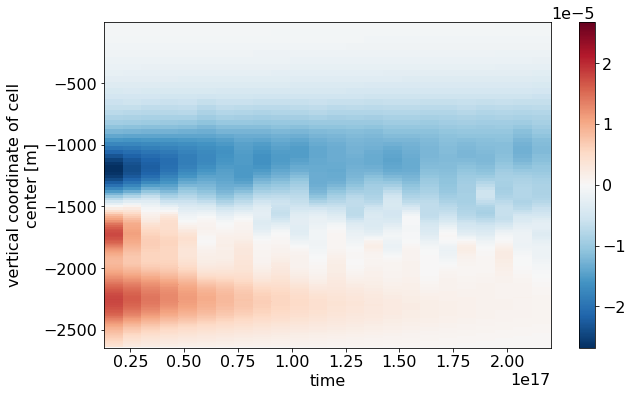

In [114]:
δTδt_integral.plot(x='time')

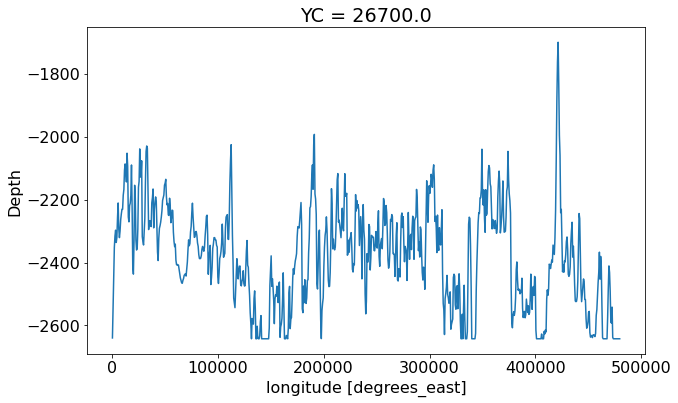

In [72]:
(-std['Depth']).isel(YC=44).plot()

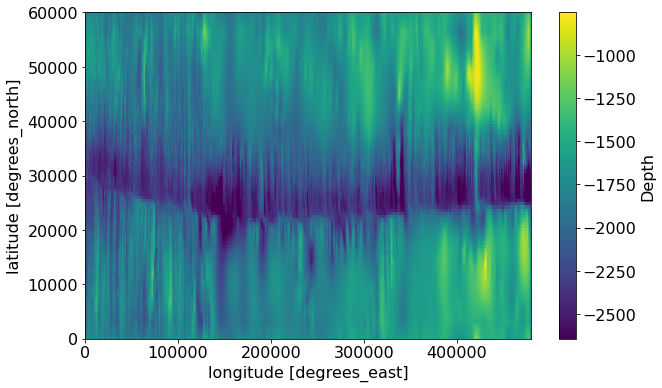

In [31]:
(-std['Depth']).plot()

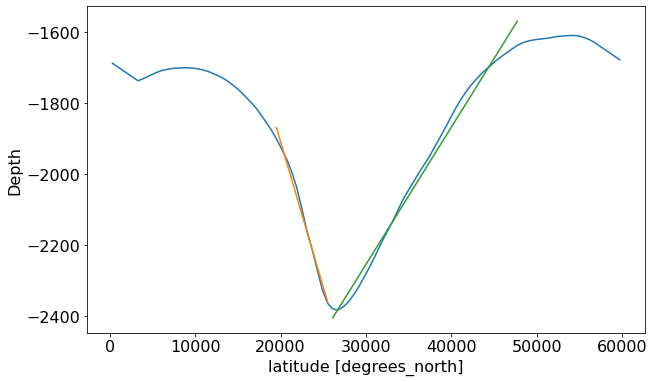

In [32]:
mx_depth = (-std['Depth']).mean(dim='XC')
my_depth = (-std['Depth']).mean(dim='YC')
mx_depth.plot()
YCsouth = [19000., 26000.]
YCnorth = [26000., 48000.]
slopesouth,_ = np.polyfit(std['YC'].sel(YC=slice(*YCsouth)), mx_depth.sel(YC=slice(*YCsouth)), deg=1)
θsouth = np.arctan(slopesouth)
plt.plot(std['YC'].sel(YC=slice(*YCsouth)), std['YC'].sel(YC=slice(*YCsouth))*np.tan(θsouth) + _)
slopenorth,_ = np.polyfit(std['YC'].sel(YC=slice(*YCnorth)), mx_depth.sel(YC=slice(*YCnorth)), deg=1)
θnorth = np.arctan(slopenorth)
plt.plot(std['YC'].sel(YC=slice(*YCnorth)), std['YC'].sel(YC=slice(*YCnorth))*np.tan(θnorth) + _)

bbl_north = bbl_exp(k0, k1, h, N, f, θnorth)
bbl_south = bbl_exp(k0, k1, h, N, f, θsouth)

In [33]:
def format_yz_section():
    plt.xlabel("cross-canyon distance [km]")
    plt.xticks(np.arange(0., 80e3, 10e3), np.arange(0, 80, 10))
    plt.xlim([0, 60e3])
    plt.ylabel("depth [m]")
    
def format_xz_section():
    plt.xlabel("along-canyon distance [km]")
    plt.xticks(np.arange(0., 500e3, 50e3), np.arange(0, 500, 50))
    plt.xlim([0, 480e3])
    plt.ylabel("depth [m]")

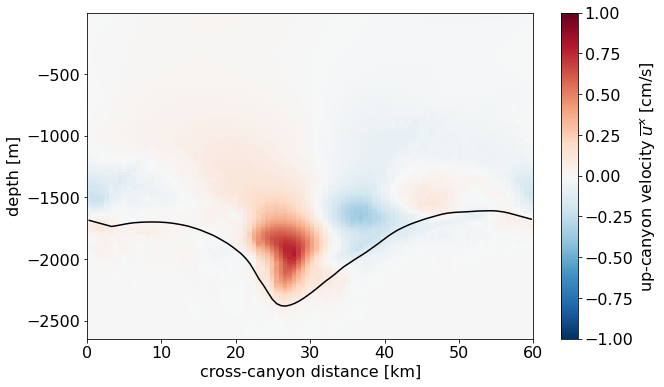

In [34]:
q = (std['UVEL']*100).mean(dim='XG').plot()
q.set_clim([-1, 1])
q.colorbar.set_label(r"up-canyon velocity $\overline{u}^{x}$ [cm/s]")
mx_depth.plot(color="k")
format_yz_section()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


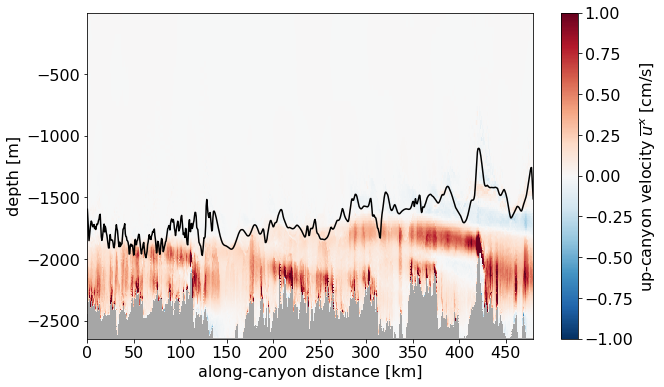

In [134]:
q = (std['UVEL']*100).where(std['hFacW']!=0.).mean(dim='YC', skipna=True).plot()
q.set_clim([-1, 1])
q.colorbar.set_label(r"up-canyon velocity $\overline{u}^{x}$ [cm/s]")
(-std['Depth']).isel(YC=np.arange(-10,10)).mean(dim='YC').plot(color="k")
format_xz_section()

(0.0, 60000.0)

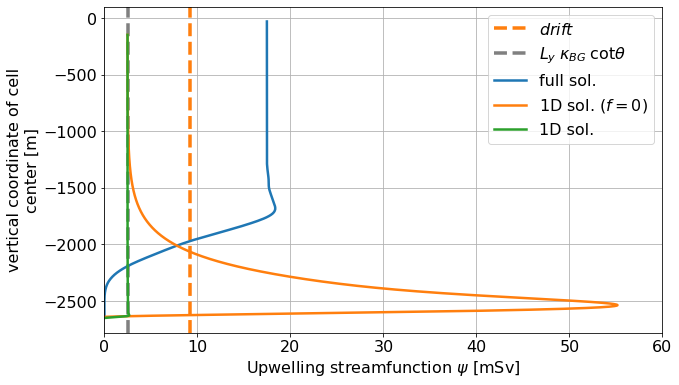

In [81]:
dy = dx;
Ly = std.YC.size*dy

δTδt_integral = (δTδt*std['drF']*600.*std['hFacC']).sum(dim=['Z', 'YC']).mean(dim='XC').compute()

plt.axvline(x=-δTδt_integral/(Γ*np.sin(θ)), color="C1", lw=3.5, linestyle="--", label=r'$drift$')

plt.axvline(x=Ly*k0*np.tan(θ)**-1, color = "grey", lw=3.5, linestyle="--", label=r'$L_{y}\; \kappa_{BG}\; \cot \theta$')

((std['UVEL']*std['drF']*dy*std['hFacW']).sum(dim='YC').mean(dim='XG'))[::-1].cumsum(dim='Z')[::-1].plot(y='Z', lw=2.5, label="full sol.")

plt.plot(np.cumsum(bbl_f0['u']*Ly*1.), bbl['z']-2650,lw=2.5,  label=r'1D sol. ($f=0$)')
plt.plot(np.cumsum(bbl['u']*Ly*1.), bbl['z']-2650,lw=2.5,  label=r'1D sol.')
plt.legend()
plt.grid(True)
plt.xlabel("Upwelling streamfunction $\psi$ [mSv]")
ticks = np.arange(0,7e4,1e4)
plt.xticks(ticks, (ticks*1e-3).astype(np.int64));
plt.xlim(0, 60e3)

In [80]:
δTδt_integral/(Γ*np.sin(θ))

<xarray.DataArray ()>
array(-9211.00704091)

In [1]:
k1/k0

NameError: name 'k1' is not defined

In [82]:
std

<xarray.Dataset>
Dimensions:  (XC: 800, XG: 800, YC: 100, YG: 100, Z: 200, Zl: 200, Zp1: 201, Zu: 200)
Coordinates:
  * XC       (XC) >f8 300.0 900.0 1.5e+03 ... 4.785e+05 4.791e+05 4.797e+05
  * YC       (YC) >f8 300.0 900.0 1.5e+03 2.1e+03 ... 5.85e+04 5.91e+04 5.97e+04
  * XG       (XG) >f8 0.0 600.0 1.2e+03 ... 4.782e+05 4.788e+05 4.794e+05
  * YG       (YG) >f8 0.0 600.0 1.2e+03 1.8e+03 ... 5.82e+04 5.88e+04 5.94e+04
  * Z        (Z) >f8 -30.99 -92.08 -151.4 ... -2.633e+03 -2.639e+03 -2.645e+03
  * Zp1      (Zp1) >f8 0.0 -61.99 -122.2 ... -2.636e+03 -2.642e+03 -2.648e+03
  * Zu       (Zu) >f8 -61.99 -122.2 -180.6 ... -2.636e+03 -2.642e+03 -2.648e+03
  * Zl       (Zl) >f8 0.0 -61.99 -122.2 ... -2.63e+03 -2.636e+03 -2.642e+03
    rA       (YC, XC) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    dxG      (YG, XC) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    dyG      (YC, XG) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    Depth    (YC, XC) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    rAz      (YG, XG) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    dxC      (YC, XG) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    dyC      (YG, XC) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    rAw      (YC, XG) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    rAs      (YG, XC) >f8 dask.array<chunksize=(100, 800), meta=np.ndarray>
    drC      (Zp1) >f8 dask.array<chunksize=(201,), meta=np.ndarray>
    drF      (Z) >f8 dask.array<chunksize=(200,), meta=np.ndarray>
    PHrefC   (Z) >f8 dask.array<chunksize=(200,), meta=np.ndarray>
    PHrefF   (Zp1) >f8 dask.array<chunksize=(201,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f8 dask.array<chunksize=(200, 100, 800), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f8 dask.array<chunksize=(200, 100, 800), meta=np.ndarray>
    hFacS    (Z, YG, XC) >f8 dask.array<chunksize=(200, 100, 800), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(200, 100, 800), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(200, 100, 800), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(200, 100, 800), meta=np.ndarray>
Data variables:
    THETA    (Z, YC, XC) float64 dask.array<chunksize=(200, 100, 800), meta=np.ndarray>
    UVEL     (Z, YC, XG) float64 dask.array<chunksize=(200, 100, 800), meta=np.ndarray>
    VVEL     (Z, YG, XC) float64 dask.array<chunksize=(200, 100, 800), meta=np.ndarray>
    WVEL     (Zl, YC, XC) float64 dask.array<chunksize=(200, 100, 800), meta=np.ndarray>
    DRHODR   (Zl, YC, XC) float64 dask.array<chunksize=(200, 100, 800), meta=np.ndarray>

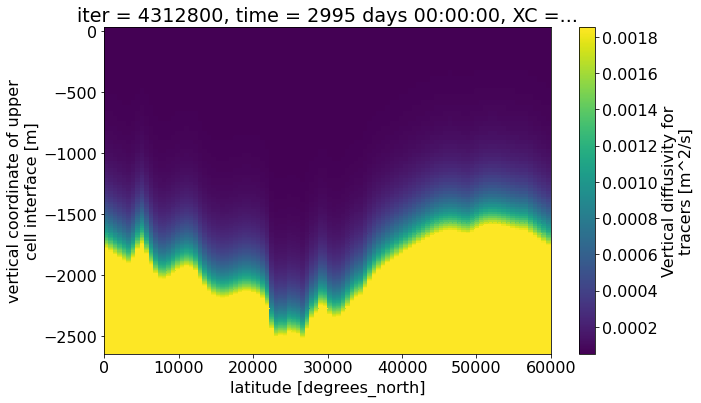

In [75]:
temp['KVDIFF'].isel(time=-1).isel(XC=400).plot()

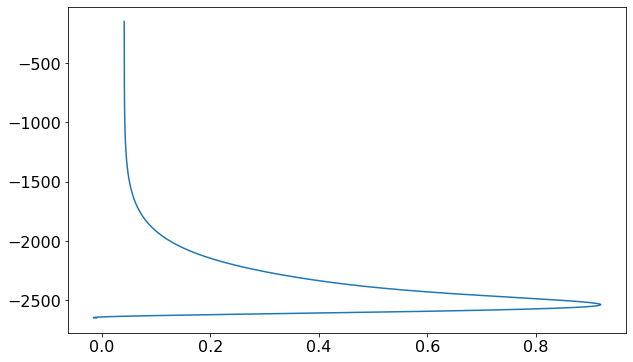

In [64]:
plt.plot(np.cumsum(bbl_f0['u']*2.), bbl['z']-2650)

In [ ]:
plt.figure(figsize=(10,4))
std['UVEL'].mean(dim='time').sel(XG=2.5e5, method='nearest').plot()
plt.xlim([60000,0])
plt.ylim([-2500, -1500])

In [ ]:
(-std['Depth']).isel(YC=44).plot()

In [ ]:
H = ds['Depth'].max().values.copy().astype('>f8')
ds, grid = preprocess(ds, θ)
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)

In [ ]:
ds = ds.chunk({'XC': 400, 'XG': 400})

In [ ]:
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['THETA_BG_U'] = Γ*ds['Zr_U']
ds['THETA_BG_V'] = Γ*ds['Zr_V']
ds['THETA_BG_W'] = Γ*ds['Zr_W']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']

In [ ]:
(ds['UVEL'].where(ds['hFacW']!=0.)*dx).sum(dim='YC', skipna=True).isel(time=-1).plot(x='Xr_U', y='Zr_U')

plt.xlim(4.1e5, 4.4e5)

In [ ]:
ds['UVEL'].sel(XG=4.1e5, method='nearest').isel(time=-1).plot()

In [ ]:
ds['UVEL'].sel(XG=4.225e5, method='nearest').isel(time=-1).plot()

In [ ]:
ds['UVEL'].sel(XG=4.5e5, method='nearest').isel(time=-1).plot()

In [ ]:
(ds['UVEL'].where(ds['hFacW']!=0.)*dx).sum(dim='YC', skipna=True)

In [ ]:
ds['DRHODR'].sum(dim='YC').isel(XC=600)

In [ ]:
ds['DRHODR'].where(ds['DRHODR']!=0.)

In [ ]:
ds['DRHODR'].where(ds['DRHODR']!=0.).mean(dim='YC', skipna=True).isel(XC=300).plot(x='iter', y='Zl')
plt.xticks(ds['iter'].values[::4], np.int64(ds['time'].values/(86400e9))[::4]);
plt.xlabel("days")

In [ ]:
ds['UVEL'].isel(YC=50, XG=600)

In [ ]:
mask1 = ~((((ds['θ'] <= 1.25) & (ds['XC'] <= -100e3)) | ((ds['θ'] >= 1.65) & (ds['XC'] >= 100e3))).isel(time=-1))
ds['TRAC01'] = ds['TRAC01'].where(mask1, 1.e-40)

mask2 = ~((((ds['θ'] <= 1.25) & (ds['XC'] <= -90e3)) | ((ds['θ'] >1.75))).isel(time=-1))
ds['TRAC02'] = ds['TRAC02'].where(mask2, 1.e-40)

## Exploratory data analysis

In [ ]:
ds['TRAC01'].isel(time=-1).sel(XC=0, method='nearest').plot()